## 实验三：基于ACL搭建VGG16实现图片分类应用

掌握使用AscendCL（Ascend Computing Language）实现模型应用的开发。将以训练好的`VGG16`网络模型(onnx格式)转换为Davinci架构专用的模型(om格式)，使`VGG16`网络推理过程可以高效的运行在Ascend硬件上。并对指定图片进行推理输出指定结果，搭建一个实时的图片分类应用。

### 1. 实验目的
本实验流程如下：
* 使用atc工具将onnx转换为om模型
* 基于python编程语言实现VGG16图片分类应用
* 基于c++编程语言实现VGG16图片分类应用

### 2. 背景介绍
### 2.1 AScendCL介绍
AscendCL（Ascend Computing Language）提供Device管理、Context管理、Stream管理、内存管理、模型加载与执行、算子加载与执行、媒体数据处理等C语言API库供用户开发深度神经网络应用，用于实现目标识别、图像分类等功能。用户可以通过第三方框架调用AscendCL接口，以便使用昇腾AI处理器的计算能力；用户还可以使用AscendCL封装实现第三方lib库，以便提供昇腾AI处理器的运行管理、资源管理能力。\
在运行应用时，AscendCL调用GE执行器提供的接口实现模型和算子的加载与执行、调用运行管理器的接口实现Device管理/Context管理/Stream管理/内存管理等。\
计算资源层是昇腾AI处理器的硬件算力基础，主要完成神经网络的矩阵相关计算、完成控制算子/标量/向量等通用计算和执行控制功能、完成图像和视频数据的预处理，为深度神经网络计算提供了执行上的保障。

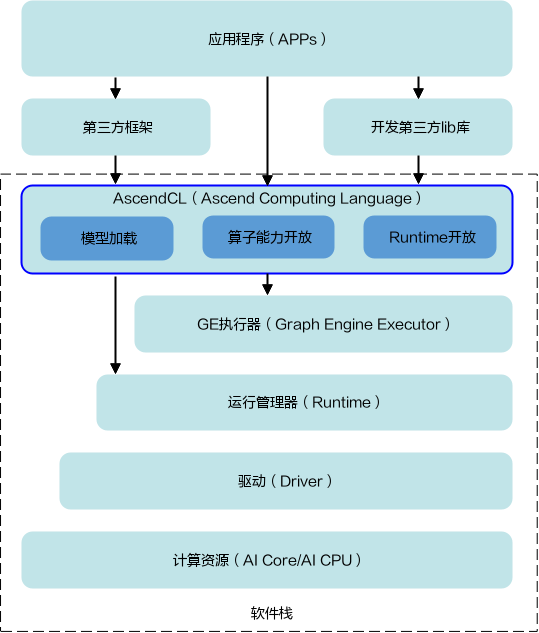

### 2.2 ATC介绍
当前昇腾AI处理器以及昇腾AI软件栈是没有办法直接拿比如Caffe，TensorFlow，Pytorch等开源框架网络模型来直接进行推理的，想要进行推理则需要做一步模型转换的步骤，将开源框架的网络模型转换成Davinci架构专用的模型。而此处模型转换的步骤就是通过本手册所要介绍的ATC工具完成的。\
昇腾张量编译器（Ascend Tensor Compiler，简称ATC）是昇腾CANN架构体系下的模型转换工具：
- 它可以将开源框架的网络模型（如Caffe、TensorFlow、Pytorch等）以及Ascend IR定义的单算子描述文件转换为昇腾AI处理器支持的离线模型。
- 模型转换过程中，ATC会进行算子调度优化、权重数据重排、内存使用优化等具体操作，对原始的深度学习模型进行进一步的调优，从而满足部署场景下的高性能需求，使其能够高效执行在昇腾AI处理器上。

### 3. 实验环境

1、环境要求：支持Ascend环境(涉及ACL推理，必须使用Ascend芯片）\
2、环境准备：已完成昇腾AI软件栈在开发环境的部署（CANN环境，需要完成驱动及CANN软件的安装，关于CANN环境的安装参考官方文档 https://support.huawei.com/enterprise/zh/doc/EDOC1100164870/e2696354 ）。

本实验依赖的python包如下：
| 依赖          | 版本     |
| ------------- | -------- |
| python        | 3.7.5    |
| c++           | 7.5.0    |
| opencv-pyhton | 4.5.3.56 |
| spicy         | 1.5.4    |
| numpy         | 1.19.4   |
| Make          | 3.10.2   |

### 4. 数据处理
### 4.1 模型文件和推理图片准备

本实验提供已经用atc工具转换好的的`.om`模型文件，并将推理图片进行预处理后送入到 VGG16 模型进行推理。

请点击数据集链接，下载以下数据集，下载的exp3_infer.zip解压，解压出 data 和 model 文件夹，和notebook同步目录，目录如下：

目录结构如下：\
./ \
|── data \
|&emsp;&emsp;&emsp;|── daisy_demo.bin \
|&emsp;&emsp;&emsp;|── daisy_demo.jpg \
|&emsp;&emsp;&emsp;|── ... \
|── model \
|&emsp;&emsp;&emsp;|── vgg16.om \
|&emsp;&emsp;&emsp;|── vgg16.onnx \
|── exp3_fully.ipynb \
|── app.py \
|── convert_model.sh \
|── ... 

权重文件和测试图片下载链接如下：
https://openi.pcl.ac.cn/attachments/62754804-f05f-4120-93bc-0e77d9c5a62a?type=0

### 4.2 数据加载
加载推理图片代码如下：

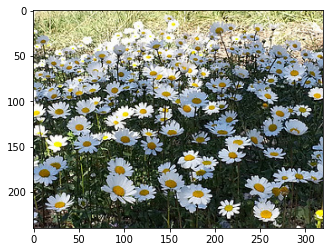

In [1]:
from matplotlib import pyplot as plt
import cv2
img_path="./data/daisy_demo.jpg"
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

### 5. 实验内容

### 5.1 设置环境
设置环境代码如下：

In [2]:
# 添加环境变量
import sys
sys.path.append("/usr/local/Ascend/ascend-toolkit/latest/python/site-packages")
sys.path.append("/usr/local/Ascend/ascend-toolkit/latest/opp/op_impl/built-in/ai_core/tbe")

import os
os.environ["LD_LIBRARY_PATH"]+="/usr/local/Ascend/driver/lib64:/usr/local/Ascend/driver/lib64/common:/usr/local/Ascend/driver/lib64/driver:"
os.environ["LD_LIBRARY_PATH"]+="/usr/local/Ascend/ascend-toolkit/latest/lib64:/usr/local/Ascend/ascend-toolkit/latest/lib64/plugin/opskernel:/usr/local/Ascend/ascend-toolkit/latest/lib64/plugin/nnengine:"
os.environ["PATH"]+="/usr/local/Ascend/ascend-toolkit/latest/bin:/usr/local/Ascend/ascend-toolkit/latest/compiler/ccec_compiler/bin:"
os.environ["ASCEND_AICPU_PATH"]="/usr/local/Ascend/ascend-toolkit/latest"
os.environ["ASCEND_OPP_PATH"]="/usr/local/Ascend/ascend-toolkit/latest/opp"
os.environ["TOOLCHAIN_HOME"]="/usr/local/Ascend/ascend-toolkit/latest/toolkit"
os.environ["ASCEND_HOME_PATH"]="/usr/local/Ascend/ascend-toolkit/latest"

# 导入相关依赖库
import struct
import time
import acl
from process import process_image
import numpy as np

In [3]:
# 设置全局变量
CLASSES = ("daisy", "roses", "sunflowers", "tulips")
ACL_MEM_MALLOC_HUGE_FIRST = 0
ACL_MEMCPY_HOST_TO_DEVICE = 1
ACL_MEMCPY_DEVICE_TO_HOST = 2
NPY_BYTE = 1

model_path="./model/vgg16.om"
img_path="./data/daisy_demo.jpg"
device_id = 0
context = None
model_id = None
model_desc = None
load_input_dataset, load_output_dataset = None, None
input_data, output_data = None, None

### 5.2 资源初始化
资源初始化代码如下：

In [4]:
# pyACL初始化
ret = acl.init()

# 运行管理资源申请
# 指定运算的Device。
device_id = 0
ret = acl.rt.set_device(device_id)
# 显式创建一个Context，用于管理Stream对象。
context, ret = acl.rt.create_context(device_id)

### 5.3 模型加载
本实验基于Ascend910转换得到的模型，基于Ascend310需要运行`convert_model.sh`，修改其中的soc_version=Ascend310，得到符合Ascend310算子的模型。
加载转换好的om模型代码如下：

In [5]:
# 加载离线模型文件，返回标识模型的ID。
model_id, ret = acl.mdl.load_from_file(model_path)

# 根据加载成功的模型的ID，获取该模型的描述信息。
model_desc = acl.mdl.create_desc()
ret = acl.mdl.get_desc(model_desc, model_id)

### 5.4 构建模型输入
准备模型推理的输入数据集，代码如下：

In [6]:
# 1.准备模型推理的输入数据集。
# 创建aclmdlDataset类型的数据，描述模型推理的输入。
load_input_dataset = acl.mdl.create_dataset()
# 获取模型输入的数量。
input_size = acl.mdl.get_num_inputs(model_desc)
input_data = []
# 循环为每个输入申请内存，并将每个输入添加到aclmdlDataset类型的数据中。
for i in range(input_size):
    buffer_size = acl.mdl.get_input_size_by_index(model_desc, i)
    # 申请输入内存。
    buffer, ret = acl.rt.malloc(buffer_size, ACL_MEM_MALLOC_HUGE_FIRST)
    data = acl.create_data_buffer(buffer, buffer_size)
    _, ret = acl.mdl.add_dataset_buffer(load_input_dataset, data)
    input_data.append({"buffer": buffer, "size": buffer_size})

# 2.准备模型推理的输出数据集。
# 创建aclmdlDataset类型的数据，描述模型推理的输出。
load_output_dataset = acl.mdl.create_dataset()
# 获取模型输出的数量。
output_size = acl.mdl.get_num_outputs(model_desc)
output_data = []
# 循环为每个输出申请内存，并将每个输出添加到aclmdlDataset类型的数据中。
for i in range(output_size):
    buffer_size = acl.mdl.get_output_size_by_index(model_desc, i)
    # 申请输出内存。
    buffer, ret = acl.rt.malloc(buffer_size, ACL_MEM_MALLOC_HUGE_FIRST)
    data = acl.create_data_buffer(buffer, buffer_size)
    _, ret = acl.mdl.add_dataset_buffer(load_output_dataset, data)
    output_data.append({"buffer": buffer, "size": buffer_size})

### 5.5 模型推理和后处理

### 5.5.1 读取图片、预处理、传输至Device
读取图片、预处理、传输至推理设备的代码如下：

In [7]:
# 1.读取并预处理图片
img = process_image(img_path)
# 2.准备模型推理的输入数据，运行模式默认为运行模式为ACL_HOST，当前实例代码中模型只有一个输入。

bytes_data = img.tobytes()
np_ptr = acl.util.bytes_to_ptr(bytes_data)

# 将图片数据从Host传输到Device。
ret = acl.rt.memcpy(input_data[0]["buffer"], input_data[0]["size"], np_ptr,
                    input_data[0]["size"], ACL_MEMCPY_HOST_TO_DEVICE)

### 5.5.2 模型推理
完成模型推理的代码如下：

In [8]:
# 3.执行模型推理。
# model_id表示模型ID，在模型加载成功后，会返回标识模型的ID。
start_time = time.time()
ret = acl.mdl.execute(model_id, load_input_dataset, load_output_dataset)
end_time = time.time()
print('inference cost time: {:.1f}ms\n'.format((end_time-start_time)*1000))

inference cost time: 9.6ms



### 5.5.3 后处理
后处理的代码如下：

In [9]:
# 4.处理模型推理的输出数据，输出置信度的类别编号。
inference_result = []
for i, item in enumerate(output_data):
    buffer_host, ret = acl.rt.malloc_host(output_data[i]["size"])
    # 将推理输出数据从Device传输到Host。
    ret = acl.rt.memcpy(buffer_host, output_data[i]["size"], output_data[i]["buffer"],output_data[i]["size"], ACL_MEMCPY_DEVICE_TO_HOST)

    bytes_out = acl.util.ptr_to_bytes(buffer_host, output_data[i]["size"])
    data = np.frombuffer(bytes_out, dtype=np.byte)
    inference_result.append(data)

tuple_st = struct.unpack("4f", bytearray(inference_result[0]))
vals = np.array(tuple_st).flatten()
top_k = vals.argsort()[-1:-6:-1]
print("\n======== inference results: =============")
for i, j in enumerate(top_k):
    print("top %d: class:[%s]: probability:[%f]" % (i, CLASSES[j], vals[j]))


======== inference results: =============
top 0: class:[daisy]: probability:[0.952637]
top 1: class:[roses]: probability:[0.026199]
top 2: class:[tulips]: probability:[0.012085]
top 3: class:[sunflowers]: probability:[0.008987]


### 5.6 模型卸载
模型卸载的代码如下：

In [10]:
# 卸载模型。
ret = acl.mdl.unload(model_id)
# 释放模型描述信息。
if model_desc:
    ret = acl.mdl.destroy_desc(model_desc)
    model_desc = None
# 释放Context。
if context:
    ret = acl.rt.destroy_context(context)
    context = None

### 5.7 释放内存
释放内存的代码如下：

In [11]:
# 释放输出资源，包括数据结构和内存。
while output_data:
    item = output_data.pop()
    ret = acl.rt.free(item["buffer"])
output_number = acl.mdl.get_dataset_num_buffers(load_output_dataset)
for i in range(output_number):
    data_buf = acl.mdl.get_dataset_buffer(load_output_dataset, i)
    if data_buf:
        ret = acl.destroy_data_buffer(data_buf)
ret = acl.mdl.destroy_dataset(load_output_dataset)

### 5.8 资源去初始化
资源去初始化的代码如下：

In [12]:
# 释放Device。
ret = acl.rt.reset_device(device_id)
# pyACL去初始化。
ret = acl.finalize()